# Dealing with infrequent apps

In [1]:
from spmf import Spmf
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = None

## Dealing with infrequency as defined by tne number of session in which an app occur

First the data is read into the program

In [2]:
data=pd.read_csv("data_sessions_20s_min_length_1.csv")

Now the number of sessions which each of the apps occure in is calculated.

In [5]:
app_in_n_sessions=data.groupby(['app_code','user_id']).session.nunique().reset_index().groupby("app_code").session.sum()

In [6]:
data=pd.merge(data, app_in_n_sessions.reset_index().rename(columns={'session':'number_of_sessions'}), how='left', on=['app_code'])

In [7]:
data['app_infrequent']=data.number_of_sessions<=(data.shape[0]/100*0.001)

In [8]:
data.shape[0]

181323205

In [9]:
data['new_session']=(data.new_session | data.app_infrequent)

In [10]:
data['updated_session']=data.groupby(['user_id']).agg({'new_session':'cumsum'}).astype('int')

In [11]:
data=data[data.app_infrequent!=True]

In [12]:
data=pd.merge(data,(data.groupby(['user_id','updated_session']).agg({'app_code':'size'})).reset_index().rename(columns={'app_code':'session_length_updated'}),how='left',on=['user_id','updated_session'])

In [13]:
data=data.drop(['session_length'],axis=1)

In [16]:
data=data[data.session_length_updated>1]

Create text file for algorithm input

In [17]:
input_string=data.groupby(['user_id','updated_session'])['app_code'].apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")

In [18]:
#update file name
input_string.to_csv("input_string_without_0_001_apps_internal_removed.csv",index=False)

In [2]:
#update file name
input_string=pd.read_csv("input_string_without_0_001_apps_internal_removed.csv")

In [19]:
print("number of updated sequences:",input_string.shape[0])

number of updated sequences: 55164865


In [3]:
dfAsString = input_string.to_string(header=False, index=False).lstrip()

In [4]:
dfAsString=re.sub(r'\n\s+','\n',dfAsString)

In [5]:
#update file name
f = open(os.path.join(os.getcwd(), '20sec_sessions_without_0_001_apps_internal_removed.txt'), 'w')
f.write(dfAsString)
f.close()

## Analysing frequency of apps in overall data set.

In [2]:
data=pd.read_csv("sorted_coded_session_20s_merged.csv")

First we take a look at the distribution of app occurrences.

In [3]:
app_count=data.groupby('app_code').size()

In [5]:
print("min number of times an app occure:",app_count.min())
print("max number of times an app occure:",app_count.max())

min number of times an app occure: 1
max number of times an app occure: 35121339


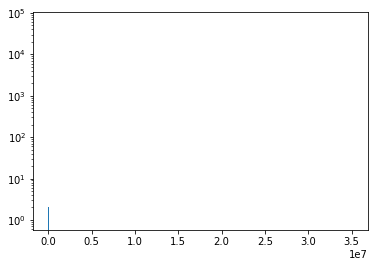

In [51]:
plt.hist(app_count,bins=range(1,app_count.max(),200))
plt.yscale('log')

In [9]:
app_count.max()

35121339

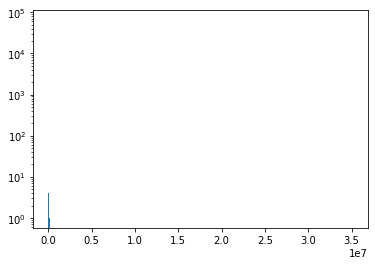

In [116]:
bins=plt.hist(app_count,bins=range(1,app_count.max()+660,1000))
plt.yscale('log')

It is clear that the majority of apps are not used that many time.

In [121]:
app_count.quantile(q=.99)

9870.650000000023

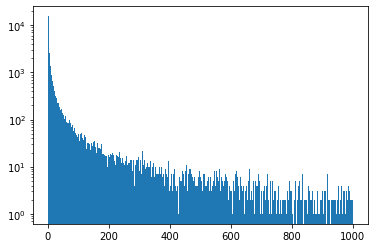

In [122]:
bins=plt.hist(app_count,bins=range(1,1001,1))
plt.yscale('log')

We now take a look at how many apps constitute at least one percent of the observations.

In [130]:
print("Number of apps which constitute at least one percent of the observations",((app_count/data.shape[0]*100)>=1).sum())

Number of apps which constitute at least one percent of the observations 17


In [135]:
print("number of observations:",data.shape[0])

number of observations: 250615269


However ~2.5 mio. obervations is still a high number.

In [139]:
print("Number of apps which constitute at least 0.1 percent of the observations",((app_count/data.shape[0]*100)>=0.1).sum())
print("Number of apps which constitute at least 0.01 percent of the observations",((app_count/data.shape[0]*100)>=0.01).sum())

Number of apps which constitute at least 0.1 percent of the observations 69
Number of apps which constitute at least 0.01 percent of the observations 329


It is overall clear that the majority of observations is made up of only a small number of differnet apps.

How many apps are needed in order to maintain 90 procent of the observations?

In [7]:
print("number of apps needed to represent 99% of the observations:",app_count.shape[0]-(((app_count.sort_values(ascending=False)/data.shape[0]*100).cumsum())>99).sum())
print("number of apps needed to represent 99.5% of the observations:",app_count.shape[0]-(((app_count.sort_values(ascending=False)/data.shape[0]*100).cumsum())>99.5).sum())
print("number of apps needed to represent 99.9% of the observations:",app_count.shape[0]-(((app_count.sort_values(ascending=False)/data.shape[0]*100).cumsum())>99.9).sum())
print("Number of different apps:",app_count.shape[0])

number of apps needed to represent 99% of the observations: 3779
number of apps needed to represent 99.5% of the observations: 6790
number of apps needed to represent 99.9% of the observations: 18871
Number of different apps: 67088


In [175]:
print("Number of observations removed if by only keeping apps, to maintain 99.5 % of the observations: ",data.shape[0]-(data.shape[0]/100*99.5))

Number of observations removed if by only keeping apps, to maintain 99.5 % of the observations:  1253076.3449999988


In [8]:
print("Number of observations removed if by only keeping apps, to maintain 99.9 % of the observations: ",data.shape[0]-(data.shape[0]/100*99.9))

Number of observations removed if by only keeping apps, to maintain 99.9 % of the observations:  250615.2689999938


We now identify the apps to maintain.

In [5]:
app_count=app_count.sort_values(ascending=False)

In [29]:
(app_count/data.shape[0]*100).cumsum().loc[29492]

99.50005919232336

In [43]:
((app_count/data.shape[0]*100).cumsum())[((app_count/data.shape[0]*100).cumsum()).shift(1)>=99.5]

app_code
45282     99.500156
55589     99.500253
10137     99.500350
16495     99.500447
46754     99.500544
            ...    
34475     99.999998
34474     99.999999
7853      99.999999
2950     100.000000
67087    100.000000
Length: 60297, dtype: float64

In [6]:
infrequent_apps=app_count[(app_count/data.shape[0]*100).cumsum().shift(1)>=99.5].index

Now that the infrequent apps have been identified, the infrequent apps can be removed. This is done after the definition of sessions, as the sleeptime should not be affected. 

In [7]:
data_sessions=pd.read_csv("data_sessions_20s_min_length_1.csv") #all sessions of length one have already been removed.

In [11]:
data_sessions[data_sessions.app_code.apply(lambda l: l in infrequent_apps)]

,package_name,user_id,start_time,end_time,time_spend,app_code,sequence_number,sequence_Start_time,sequence_end_time,sleep_time,new_session,session,session_length
58,com.acobot.en,0,88663,89439,776,6364,70,88663,89439,0,False,30,2
351,com.sirmamobile.prodavalnik,0,692893,693054,161,44393,409,692893,693054,0,False,202,4
362,com.sirmamobile.prodavalnik,0,733249,733810,561,44393,420,733249,733810,10,False,206,5
365,com.sirmamobile.prodavalnik,0,734511,734931,420,44393,422,734511,734931,0,False,206,5
378,com.sirmamobile.prodavalnik,0,766616,766626,10,44393,443,766616,766626,0,False,218,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181311433,com.tpvapps.simpledrumsdeluxe,9998,35996905,35997145,240,49759,9408,35996905,35997145,20,False,5206,4
181313147,com.adactus.brunel,9999,3895488,3895750,262,6477,1507,3895488,3895750,844,True,931,2
181316610,air.nn.mobile.app.main,9999,13593307,13593365,58,1312,6287,13593307,13593365,0,False,3715,3
181317050,air.nn.mobile.app.main,9999,14809642,14809652,10,1312,6897,14809642,14809652,0,False,4070,3


In [15]:
print("Number of observations to delete from dataframe:",910595/data_sessions.shape[0]*100)

Number of observations to delete from dataframe: 0.5021944102521241


In [16]:
data_sessions["infrequent_app"]=data_sessions.app_code.apply(lambda l: l in infrequent_apps)

In [18]:
data_sessions['new_session']=(data_sessions.new_session | data_sessions.infrequent_app)

In [19]:
data_sessions['updated_session']=data_sessions.groupby(['user_id']).agg({'new_session':'cumsum'}).astype('int')

In [21]:
data_sessions=data_sessions[data_sessions.infrequent_app!=True]

In [23]:
data_sessions.shape[0]

180412610

In [34]:
data_sessions=pd.merge(data_sessions,(data_sessions.groupby(['user_id','updated_session']).agg({'app_code':'size'})).reset_index().rename(columns={'app_code':'session_length_updated'}),how='left',on=['user_id','updated_session'])

In [35]:
data_sessions=data_sessions.drop(['session_length'],axis=1)

In [37]:
data_sessions=data_sessions[data_sessions.session_length_updated>1]

After the removal of infrequent apps, the text filed used for running the mining algorithms can now be created.

In [41]:
input_string=data_sessions.groupby(['user_id','updated_session'])['app_code'].apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")

In [42]:
#update file name
input_string.to_csv("input_string_apps_removed_to_keep_99_5.csv",index=False)

In [2]:
input_string=pd.read_csv("input_string_apps_removed_to_keep_99_5.csv")

In [43]:
print("number of updated sequences:",input_string.shape[0])

number of updated sequences: 56147456


In [3]:
dfAsString = input_string.to_string(header=False, index=False).lstrip()

In [4]:
dfAsString=re.sub(r'\n\s+','\n',dfAsString)

In [5]:
#update file name
f = open(os.path.join(os.getcwd(), '20sec_sessions_apps_removed_to_keep_99_5.txt'), 'w')
f.write(dfAsString)
f.close()

## defining infrequency based on percentage of occurences.

In [8]:
data=pd.read_csv("sorted_coded_session_20s_merged.csv")

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
app_count=data.groupby('app_code').size()